# NYC schools
---
This is a guided project from [Dataquest.io](https://www.dataquest.io/m/217/guided-project-analyzing-nyc-high-school-data)

It focuses on combining, exploring and expressing findings on NYC schools data.
Primarily we'll explore different correlations to SAT score school performance. Such as:
 - ethnicity
 - gender
 - survey results
 - AP tests
 
Findings are expressed as conclusions after each explored question.

Enjoy vividly placed results!

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

*sat_score* correlation to all columns

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

*sat_score* correlation to *survey_fields* columns. Build bars plots to see visually.

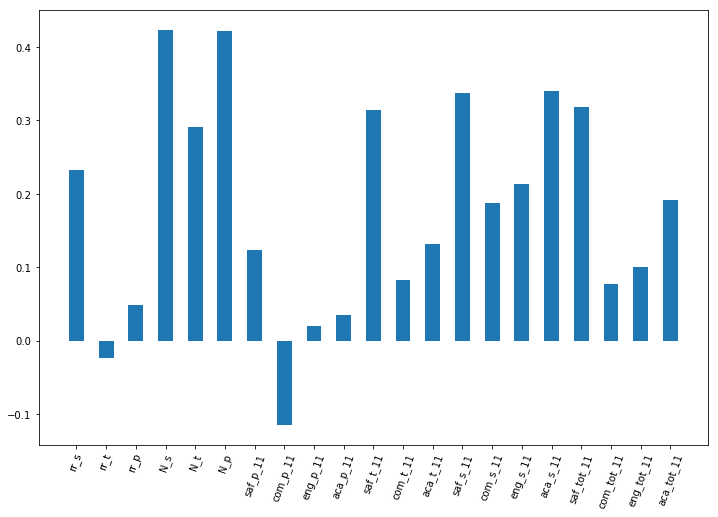

In [10]:
import matplotlib.pyplot as plt

correlations_survey = correlations.loc[survey_fields].dropna()

fig,ax = plt.subplots(figsize=(12,8))
bar_pos = range(len(correlations_survey))
bar_width = 0.5
ax.bar(bar_pos, correlations_survey, bar_width)
#plt.show()

ax.set_xticks(bar_pos)
ax.set_xticklabels(correlations_survey.index.values, rotation=70)

plt.show()
#for spine in ax.spines.values():
#    spine.set_visible(False)

### Findings
Highest correlations with rr_p (parent response rate) and N_t (number of teacher respondents) columns observed - well, the schools with more participants in survery correlate to higher sat rate. Probably because parents in those schools have more responsible attitude.

Safety and respect level has hight correlation with sat, which is not surprising. Because students tend to perform better in safe environment. Interesting that parents were not that accurate in defining safety score, so their correlation is weaker.

Students academic expectations tend to have better correlation that that of their parents and teachers. Students perceive and know themselves better.

Hight stundent response rate correlates to sat level, which is expected, as students that complete survey probably would have better academic performance.

# Explore Safety Score

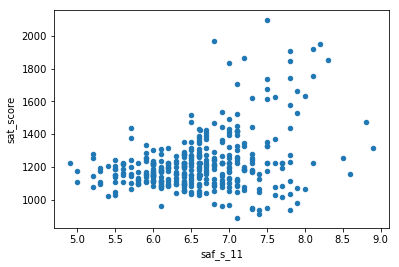

In [11]:
combined.plot.scatter("saf_s_11", "sat_score")
plt.show()

### Findings
Correlation for safety level is quite evident from the scatterplot.

Mapping out the safety levels.

In [12]:
import numpy
districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)
districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


C:\Users\Saber\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\Saber\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


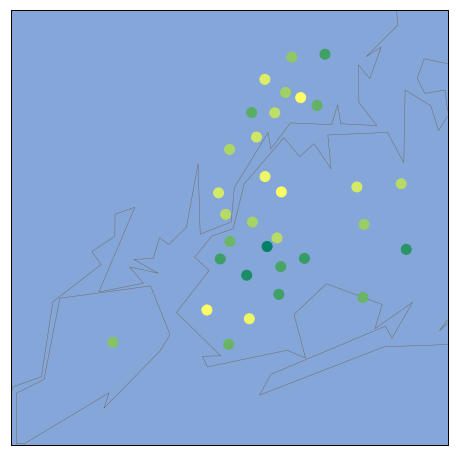

In [13]:
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(12,8))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes,latitudes,
          s=100,
          zorder=2, 
          latlon=True,
          c=districts['saf_s_11'], cmap='summer')

plt.show()

### Findings
_ (Yellow colors represent higher values, greens stand for lower values) _

North Brooklyn seems to be least safe place to study.

Most safe place as perceived by students are south Brooklyn, West Queens and South West Bronx

# Racial Differences to SAT score
---
Explore racial differences in SAT scores. First by exploring correlation to race percentage:
- white_per
- asian_per
- black_per
- hispanic_per

Explore schools with high and low SAT in relation to hispanic percentage.

Explore schools with hispanic percentage > 95%

Explore schools with hispanice percentage < 10% and average SAT score > 1800


## Visualize race percentage correlation to SAT score

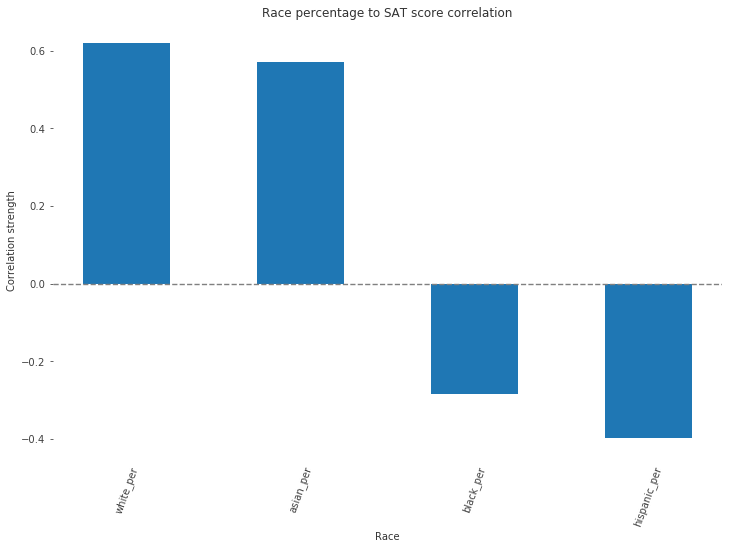

In [23]:
import matplotlib.pyplot as plt

race_columns = ['white_per','asian_per','black_per','hispanic_per']
correlations_race = correlations.loc[race_columns].dropna()

fig,ax = plt.subplots(figsize=(12,8))
bar_pos = range(len(correlations_race))
bar_width = 0.5
ax.bar(bar_pos, correlations_race, bar_width)
#plt.show()

ax.set_title('Race percentage to SAT score correlation', alpha=0.8)
ax.set_xticks(bar_pos)
ax.set_xticklabels(correlations_race.index.values, rotation=70)
ax.set_ylabel('Correlation strength', alpha=0.8)
ax.set_xlabel('Race', alpha=0.8)

ax.axhline(0, lw=1.4, linestyle='--', color='gray')

ax.tick_params(axis='both', top='off', bottom='off', left='on', right='off',
               labelleft='on', labelbottom='on',
               color='#404040',
               labelcolor='#404040')
for i,spine in enumerate(ax.spines.values()):
    spine.set_visible(False)

plt.show()

### Findings
There is an evident race correlation for race and SAT score.

Strong positive correlation to SAT score for whites and asians.

Negative correlation to SAT score for blacks and hispanic prevailing schools. Reaching it's strongest negative for schools with high hispanic percentage.

## High and Low SAT school to hispanic race percentage
---
A scatter plot would show the relation.

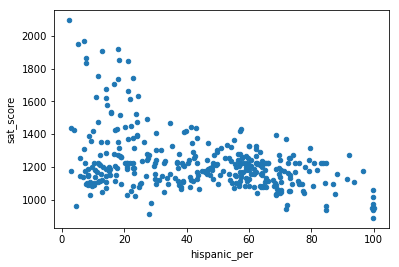

In [43]:
#fig, ax = plt.subplots(figsize=(8,8))
ax = combined.plot.scatter('hispanic_per','sat_score')
fig = plt.gcf()
#fig.figsize(8,8)
plt.show()

### Findings
Highest SAT is achieved for schools with low hispanic students percentage.

There is a cluster of schools with high percentage of hispanice students around 60%. None of those schools achieve high SAT.

There is a cluster of schools with 100% hispanic students, with lowest SAT score of all.

## Schools with 95% hispanics
Explore more vividly cluster of schools with highest hispanic student percentage. Search info on them.

In [55]:
hispanic_schools = combined[combined['hispanic_per']>95]
print(hispanic_schools.loc[:,['SCHOOL NAME','sat_score']])

                                           SCHOOL NAME  sat_score
44                       MANHATTAN BRIDGES HIGH SCHOOL     1058.0
82    WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL     1174.0
89   GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...     1014.0
125                ACADEMY FOR LANGUAGE AND TECHNOLOGY      951.0
141              INTERNATIONAL SCHOOL FOR LIBERAL ARTS      934.0
176   PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE      970.0
253                          MULTICULTURAL HIGH SCHOOL      887.0
286             PAN AMERICAN INTERNATIONAL HIGH SCHOOL      951.0


### Findings
The schools are aimed for multicultural children, mostly for adaptating migrants.

## Schools with high SAT and < 10% hispanics
Let's explore best performing schools with low hispanic percentage, and best SAT scores

In [57]:
best_performing_schools = combined[(combined['sat_score']>1800) & (combined['hispanic_per']<10)]
print(best_performing_schools.loc[:,['SCHOOL NAME','sat_score']])

                                           SCHOOL NAME  sat_score
37                              STUYVESANT HIGH SCHOOL     2096.0
151                       BRONX HIGH SCHOOL OF SCIENCE     1969.0
187                     BROOKLYN TECHNICAL HIGH SCHOOL     1833.0
327  QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...     1868.0
356                STATEN ISLAND TECHNICAL HIGH SCHOOL     1953.0


### Findings
These are selective-disciplinarian schools focusing on science with extra funding.

## Gender correlations with SAT
---
Find out if there are any differences and correlations for gender percentage in schools.

Explore high sat schools with female students > 60%

### Gender differences

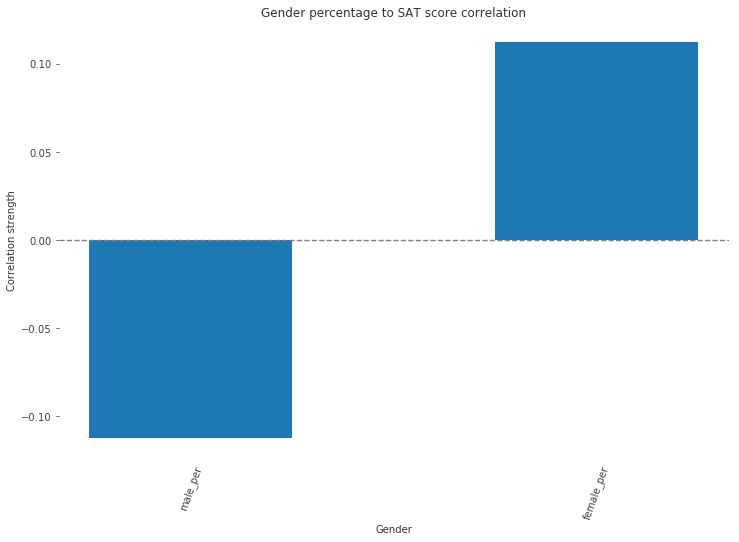

In [59]:
race_columns = ['male_per','female_per']
correlations_types = correlations.loc[race_columns].dropna()

fig,ax = plt.subplots(figsize=(12,8))
bar_pos = range(len(correlations_types))
bar_width = 0.5
ax.bar(bar_pos, correlations_types, bar_width)
#plt.show()

ax.set_title('Gender percentage to SAT score correlation', alpha=0.8)
ax.set_xticks(bar_pos)
ax.set_xticklabels(correlations_types.index.values, rotation=70)
ax.set_ylabel('Correlation strength', alpha=0.8)
ax.set_xlabel('Gender', alpha=0.8)

ax.axhline(0, lw=1.4, linestyle='--', color='gray')

ax.tick_params(axis='both', top='off', bottom='off', left='on', right='off',
               labelleft='on', labelbottom='on',
               color='#404040',
               labelcolor='#404040')
for i,spine in enumerate(ax.spines.values()):
    spine.set_visible(False)

plt.show()

### Findings
Unexpectedly there are small gender-wise correltions: negative 10% for male, positive 10% for females.

## Explore female-sat correlation for high values
Investigate schools with high SAT scores and a high `female_per`. Visualize via scatterplot.

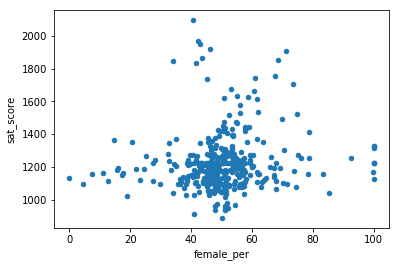

In [60]:
#fig, ax = plt.subplots(figsize=(8,8))
ax = combined.plot.scatter('female_per','sat_score')
fig = plt.gcf()
#fig.figsize(8,8)
plt.show()

### Findings
Massive amounts of schools are concentrated with gender ratio 50:50.

However there are several clusters to and interesting observations.
1. Schools with strong skewed ratio, i.e. either predominantly female or male do not display highest SAT scores.
2. There are two branches (clusters) of schools with bes SAT scores, both have slight skew:
    - "male-prevailing branch", with ~40% females have best sats
    - "female-prevaukubg branch", with ~60% females have high sats
3. Cluster of 100% female students with SAT score above average.

## Explore 60% female schools with high SAT

In [65]:
female_schools = combined[(combined['female_per']>60) & (combined['sat_score']>1700)]
print(female_schools.loc[:,['SCHOOL NAME','sat_score']])

                                           SCHOOL NAME  sat_score
5                       BARD HIGH SCHOOL EARLY COLLEGE     1856.0
26                       ELEANOR ROOSEVELT HIGH SCHOOL     1758.0
60                                  BEACON HIGH SCHOOL     1744.0
61   FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...     1707.0
302                        TOWNSEND HARRIS HIGH SCHOOL     1910.0


### Findings
Those are the schools with extra fundings admitting students on exam and portfolio based selection. Specialize mostly in cultural subjects, thus, probably more female populated.

## AP exams correlation
In the U.S., high school students take [Advanced Placement](https://en.wikipedia.org/wiki/Advanced_Placement_exams) (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship.

### Investigate the relationship between AP scores and SAT scores
Calculate the percentage of students in each school that took an AP exam.

Investigate the relationship between AP scores and SAT scores.

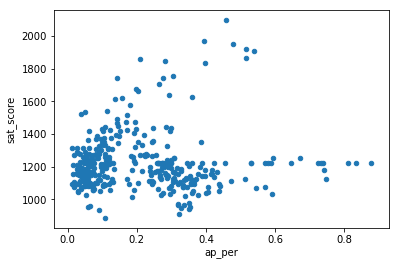

In [67]:
# Percentage of AP test takers per school
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

# Visualize relationship via scatterplot
ax = combined.plot.scatter('ap_per','sat_score')
fig = plt.gcf()
plt.show()

### Findings
There is a "crescent" cluster of higher SAT scores. The crescent cluster as a separate entity shows a strong correlation for sat AP test takers percentage and SAT scores.

All the rest (most) schools have not much correlation observed, even for highest AP taker percentage, probably because those schools have manadatory AP.

## Conclusion
Some Interesting questions were answered. Data-driven results and findings display it most clearly.

Yet, there are more interesting questions to explore. Please see [Deep Explorations on NYC schools](https://github.com/SilverSurfer0/dataquest/blob/master/solutions/NYC_schools_exploration.ipynb) dataset. *Which ultimately answers the question: which district is the best to move into in respect to school and living expenses.*